# <center>Parameters selection

In [1]:
import os
workdir = "../.."
os.chdir(workdir)

%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('fivethirtyeight')

In [3]:
from sklearn import linear_model
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import scipy as sc
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from numpy.linalg import LinAlgError

from itertools import product

import warnings

In [4]:
from datetime import datetime, timedelta

In [5]:
import json

In [6]:
import tqdm

In [7]:
from processing.common import read_data, data_preprocessing, data_split, calc_sMAE
from settings import data_path, path_to_model
from models.forecast import SalesForecast

## Замечание о данных для подбора параметров

Для подбора параметров будем использовать данные без последних 31 дней. На этих 31 дней мы будем впоследствии валидировать модели, построенные для каждого из магазинов.

## Готовим данные   

In [8]:
store_id = 17

In [9]:
data = read_data(store_id)

In [10]:
data = data_preprocessing(data, store_id)

In [11]:
prediction_horizon = 31
data, _ = data_split(data, prediction_horizon)

## Посмотрим на данные, изучим визуально сезонность

In [12]:
target_col = "target"

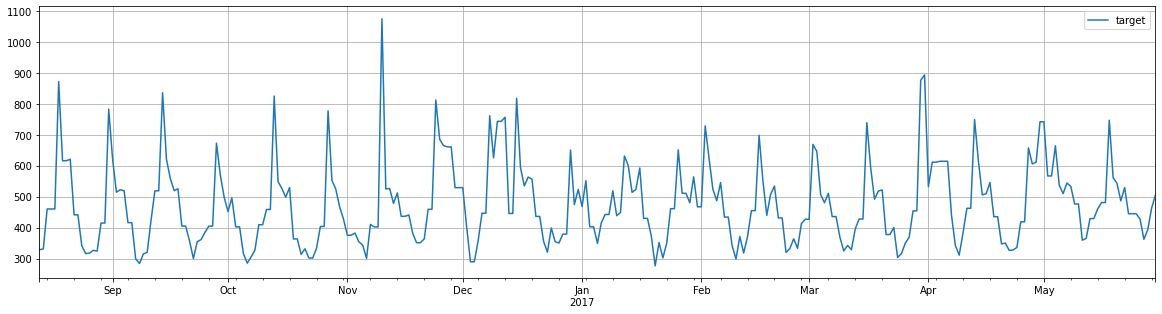

In [13]:
plt.figure(figsize=(20, 5))
data[target_col].plot()
plt.legend()
plt.grid()

## Создадим регрессионные признаки для учёта сезонностей и трендов.

In [14]:
# для недельной сезонности
k_season_series = [1, 2, 3, 4, 5, 6]
hours_in_week = 168 # число часов в неделе
for i in k_season_series:
    data[f'weekly_SIN_{i}'.replace(".", "_")] = np.sin((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)
    data[f'weekly_COS_{i}'.replace(".", "_")] = np.cos((np.arange(len(data)) + 1) * 2*np.pi * i / hours_in_week)

In [15]:
# конец и начало месяца
data['month_end'] = data.index.is_month_end.astype(int)
data['month_start'] = data.index.is_month_start.astype(int)

Добавим в датафрейм день недели и выходной в качестве категориальных переменных

In [16]:
data["weekday"] = data.index.weekday
data['is_weekend'] = data.weekday.isin([5,6]).astype(int)
data.head()

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend
2016-08-13,328.5,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,0.974928,0,0,5,1
2016-08-14,331.1,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,0.900969,0,0,6,1
2016-08-15,460.2,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,0.781831,0,0,0,0
2016-08-16,460.2,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,0.623490,0,0,1,0
2016-08-17,460.2,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,0.433884,0,0,2,0


Добавим признак четной и нечетной недели

In [17]:
data['is_even_week'] = ((data.index.isocalendar().week % 2).astype(int) == 0).astype(int)

In [18]:
data.head(10)

,target,weekly_SIN_1,weekly_COS_1,weekly_SIN_2,weekly_COS_2,weekly_SIN_3,weekly_COS_3,weekly_SIN_4,weekly_COS_4,weekly_SIN_5,weekly_COS_5,weekly_SIN_6,weekly_COS_6,month_end,month_start,weekday,is_weekend,is_even_week
2016-08-13,328.5,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,0.222521,9.749279e-01,0,0,5,1,1
2016-08-14,331.1,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,0.433884,9.009689e-01,0,0,6,1,1
2016-08-15,460.2,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,0.623490,7.818315e-01,0,0,0,0,0
2016-08-16,460.2,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,0.781831,6.234898e-01,0,0,1,0,0
2016-08-17,460.2,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,0.900969,4.338837e-01,0,0,2,0,0
2016-08-18,871.4,0.222521,0.974928,0.433884,0.900969,0.623490,0.781831,0.781831,0.623490,0.900969,0.433884,0.974928,2.225209e-01,0,0,3,0,0
2016-08-19,615.9,0.258819,0.965926,0.500000,0.866025,0.707107,0.707107,0.866025,0.500000,0.965926,0.258819,1.000000,6.123234e-17,0,0,4,0,0
2016-08-20,616.0,0.294755,0.955573,0.563320,0.826239,0.781831,0.623490,0.930874,0.365341,0.997204,0.074730,0.974928,-2.225209e-01,0,0,5,1,0
2016-08-21,620.8,0.330279,0.943883,0.623490,0.781831,0.846724,0.532032,0.974928,0.222521,0.993712,-0.111964,0.900969,-4.338837e-01,0,0,6,1,0
2016-08-22,441.2,0.365341,0.930874,0.680173,0.733052,0.900969,0.433884,0.997204,0.074730,0.955573,-0.294755,0.781831,-6.234898e-01,0,0,0,0,1


## Регрессия целевого признака

In [19]:
# Список призднаков для регрессии
feature_list = []
feature_list = data.drop(target_col, axis=1).columns
feature_list

Index(['weekly_SIN_1', 'weekly_COS_1', 'weekly_SIN_2', 'weekly_COS_2',
       'weekly_SIN_3', 'weekly_COS_3', 'weekly_SIN_4', 'weekly_COS_4',
       'weekly_SIN_5', 'weekly_COS_5', 'weekly_SIN_6', 'weekly_COS_6',
       'month_end', 'month_start', 'weekday', 'is_weekend', 'is_even_week'],
      dtype='object')

### use smf.ols

In [20]:
m1 = smf.ols('target ~ ' + ' + '.join(feature_list), data=data)
# fitted = m1.fit()
fitted = m1.fit(cov_type='HC1')
print(fitted.summary())

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.214
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     4.094
Date:                Wed, 15 Sep 2021   Prob (F-statistic):           2.58e-07
Time:                        10:10:17   Log-Likelihood:                -1797.9
No. Observations:                 291   AIC:                             3632.
Df Residuals:                     273   BIC:                             3698.
Df Model:                          17                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      491.1864     14.052     34.954   

Посмотрим на остатки

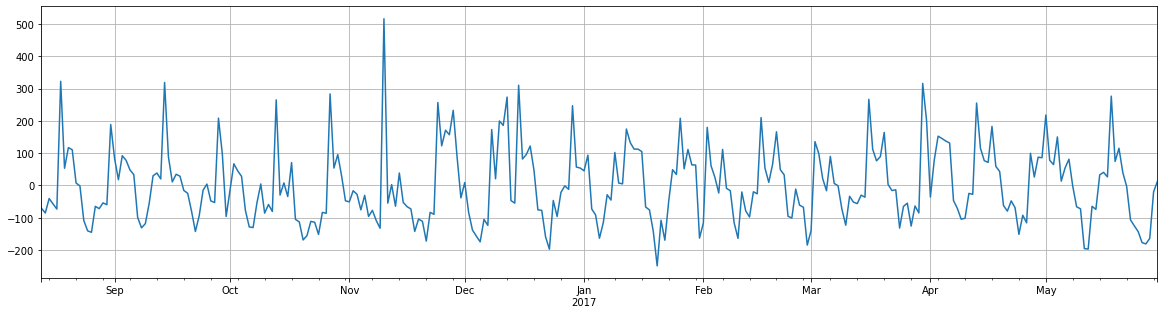

In [21]:
plt.figure(figsize=(20, 5))
fitted.resid.plot();
plt.grid()

В остатках много структуры.

Посмотрим на распределение остатков

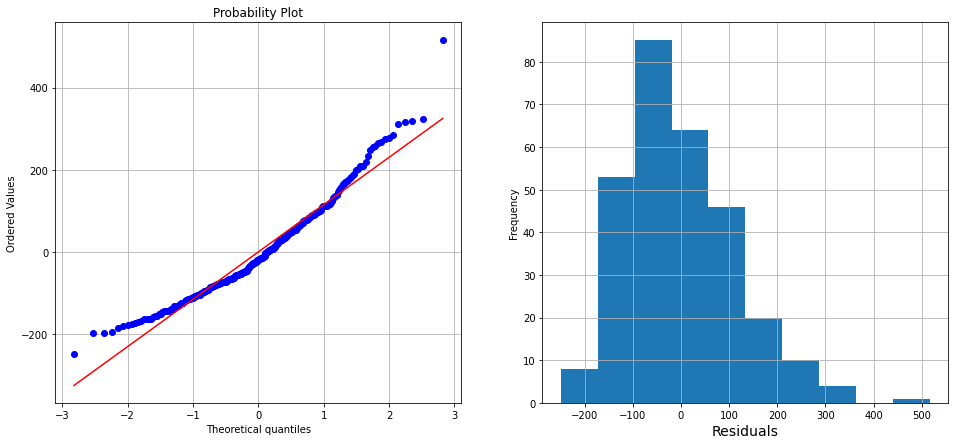

In [22]:
plt.figure(figsize=(16,7))
plt.subplot(121)
sc.stats.probplot(fitted.resid, dist="norm", plot=plt)
plt.grid()
plt.subplot(122)
fitted.resid.plot.hist()
plt.xlabel('Residuals', fontsize=14)
plt.grid()

Распределение близко к гауссову, сделаем некоторые преобразования, чтобы еще более приблизить его к гауссову и к стационарному

## Подбор значения гиперпараметров ARIMA

Посмотрим на **STL-декомпозицию**

Критерий Дики-Фуллера: p=4.134177e-04


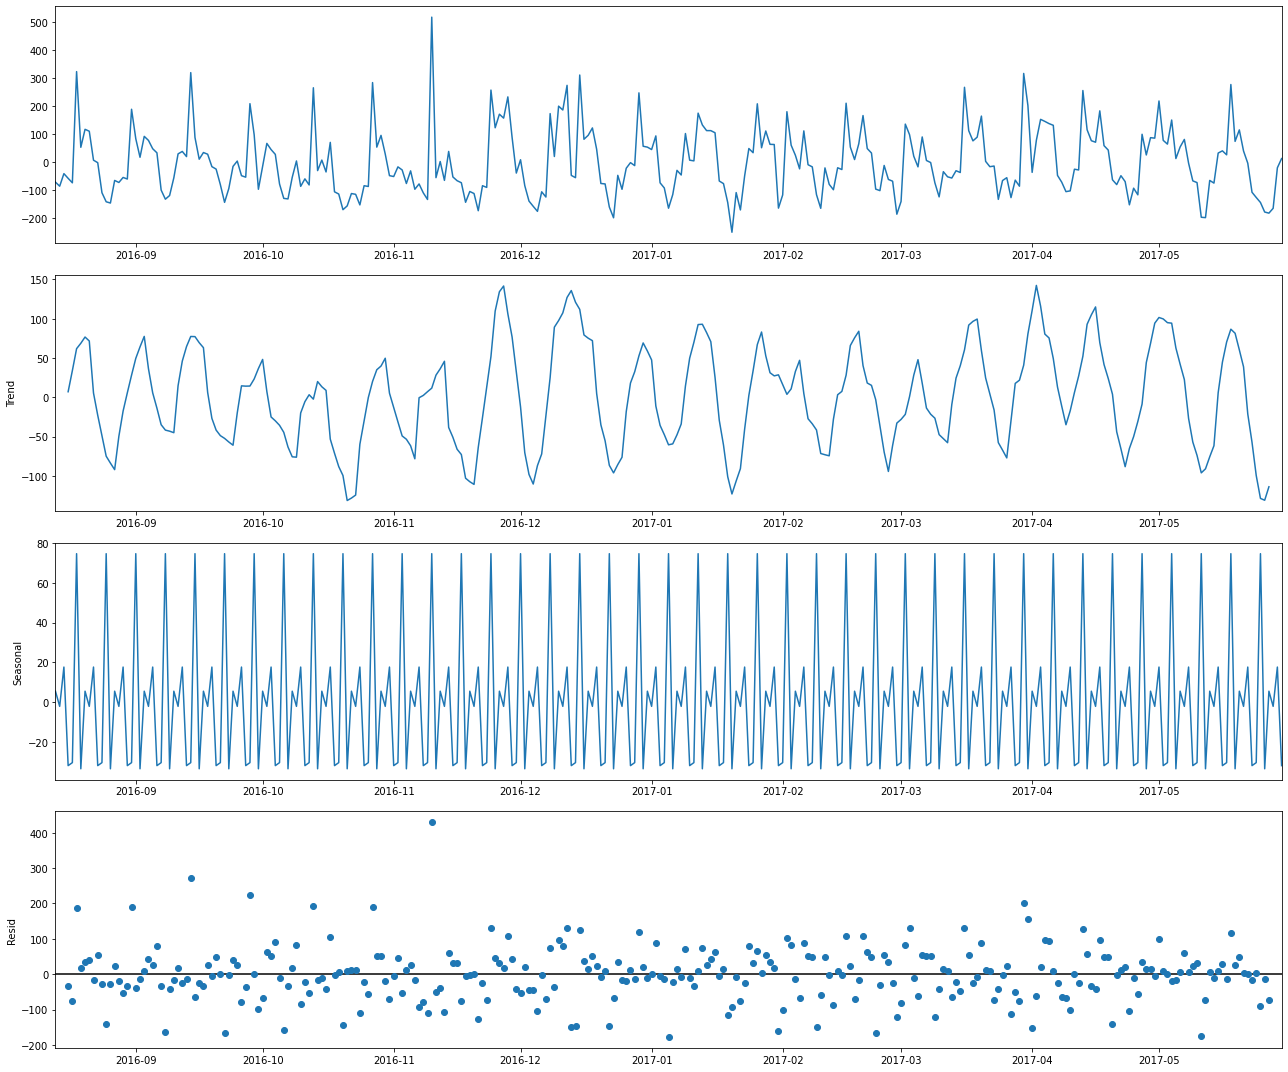

In [23]:
plt.rcParams["figure.figsize"] = (18,15)
sm.tsa.seasonal_decompose(fitted.resid).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(fitted.resid)[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, НО, на мой взгляд, не очень уверенно.    
Напрашивается дифференцирование.   

In [24]:
col = {}
lag = 1

Критерий Дики-Фуллера: p=3.668331e-11


<Figure size 1080x720 with 0 Axes>

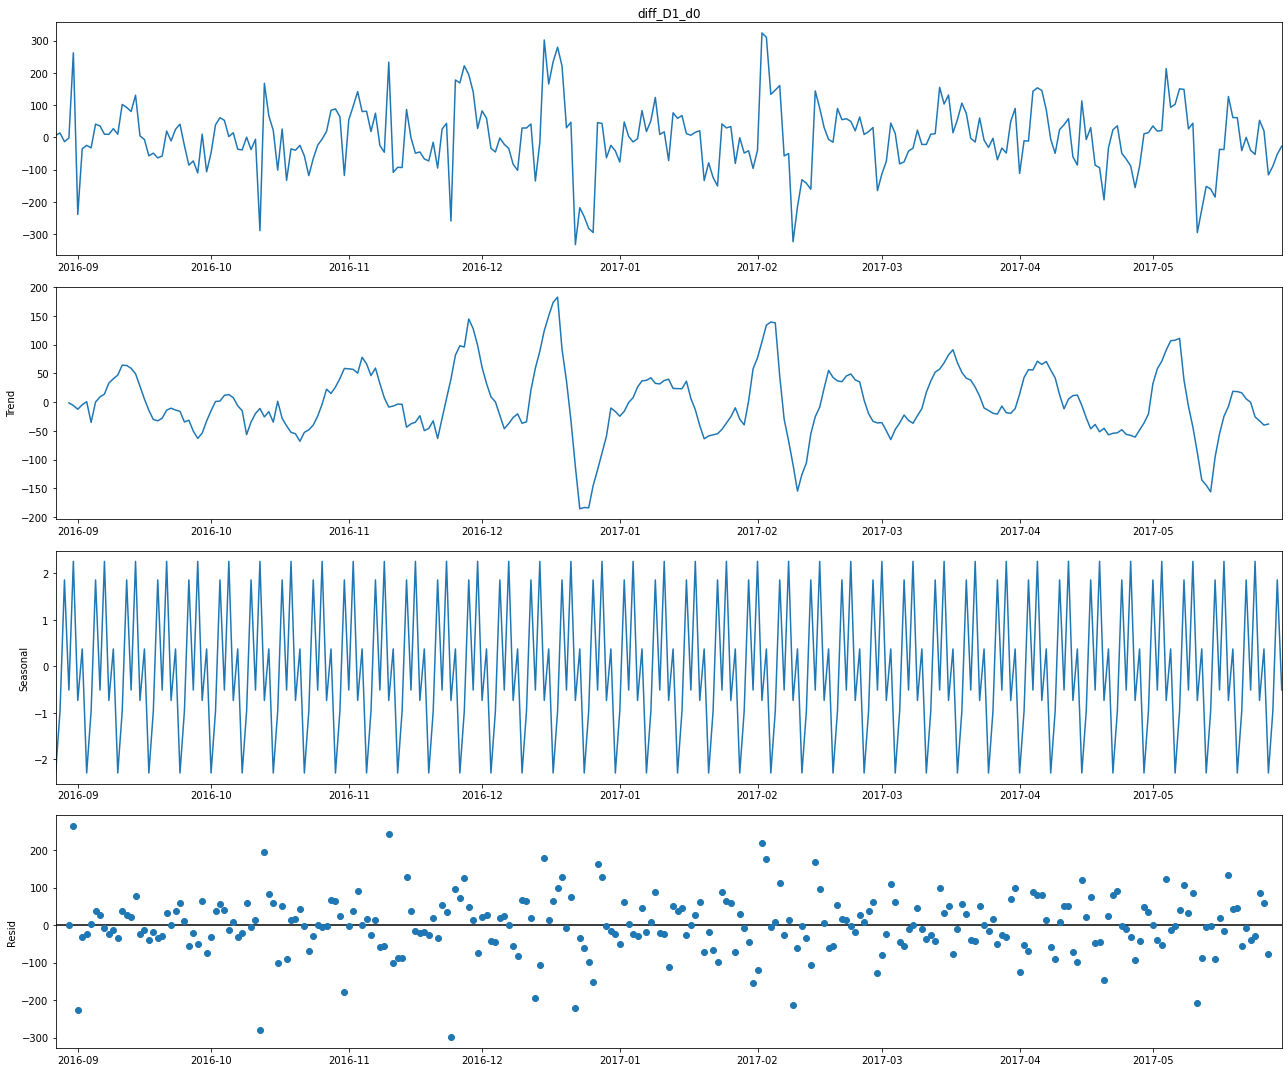

In [25]:
D = 1
S = 14
d = 0
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = fitted.resid - fitted.resid.shift(S)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера: p=2.831417e-12


<Figure size 1080x720 with 0 Axes>

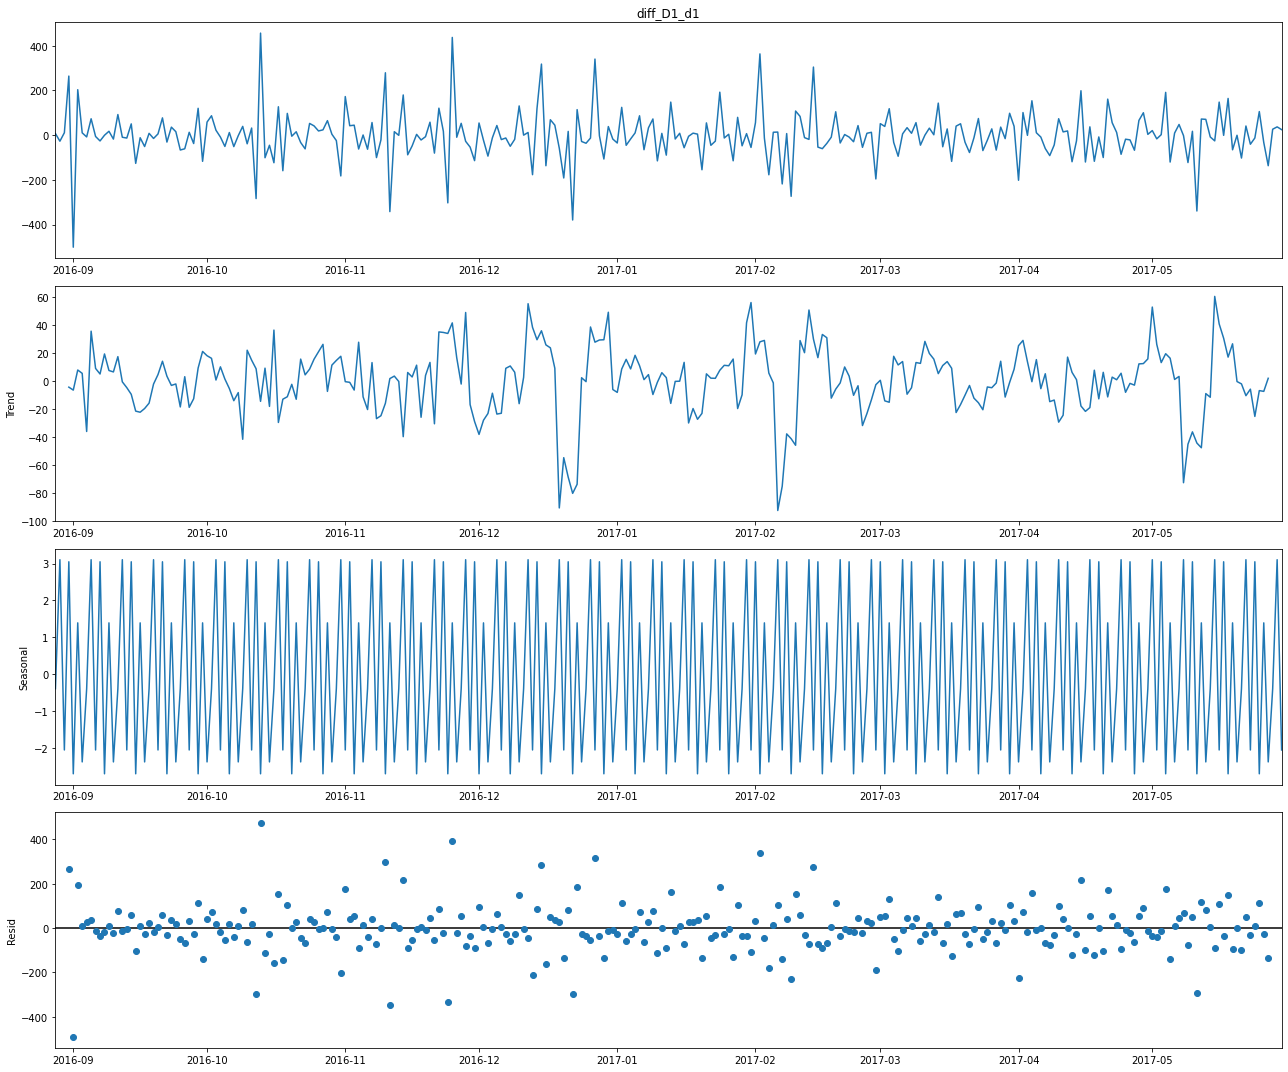

In [26]:
D = 1
S = S
d = 1
col[(D, d)] = f"diff_D{D}_d{d}"

plt.rcParams["figure.figsize"] = (18,15)
data[col[(D, d)]] = data[col[(D, d-1)]] - data[col[(D, d-1)]].shift(lag)
plt.figure(figsize=(15,10))
sm.tsa.seasonal_decompose(data[col[(D, d)]][(D*S+d*lag):]).plot()
print("Критерий Дики-Фуллера: p=%e" % sm.tsa.stattools.adfuller(data[col[(D, d)]][(D*S+d*lag):])[1])

Критерий Дики-Фуллера позволяет считать ряд стационарным.   
Мы провели два дифференцирования - сезонное (сезон = 14 дней) и соседних значений.   

### подбираем p,q,P,Q

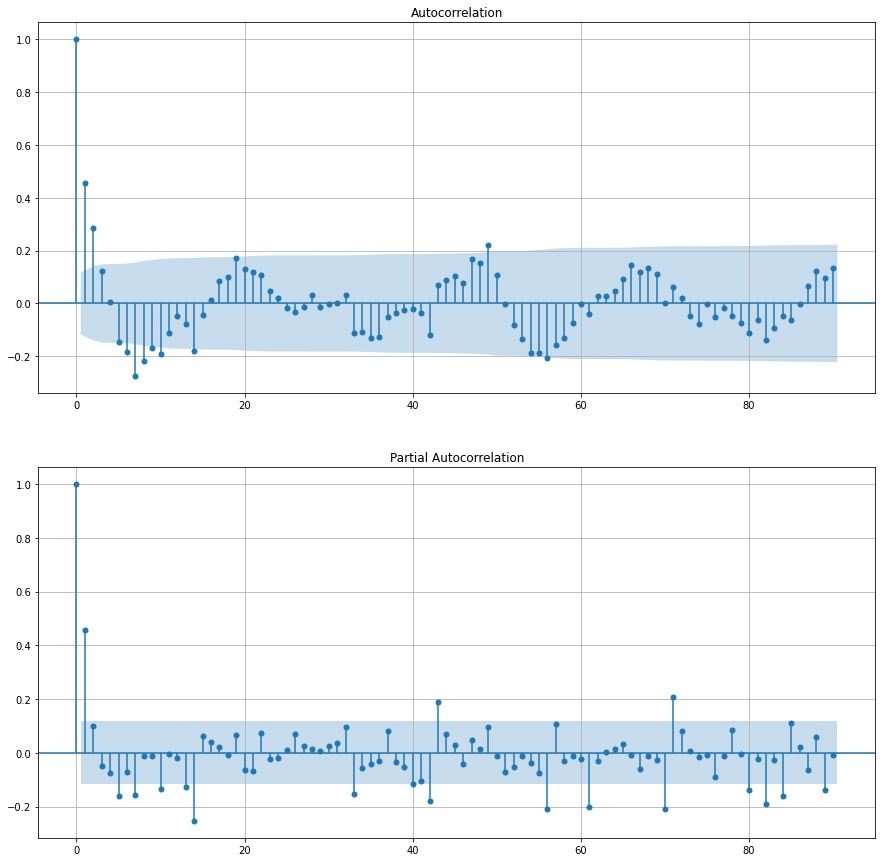

In [27]:
D = 1
d = 0

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

D:\Users\dsher\PycharmProjects\sales_forecast_model\venv\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


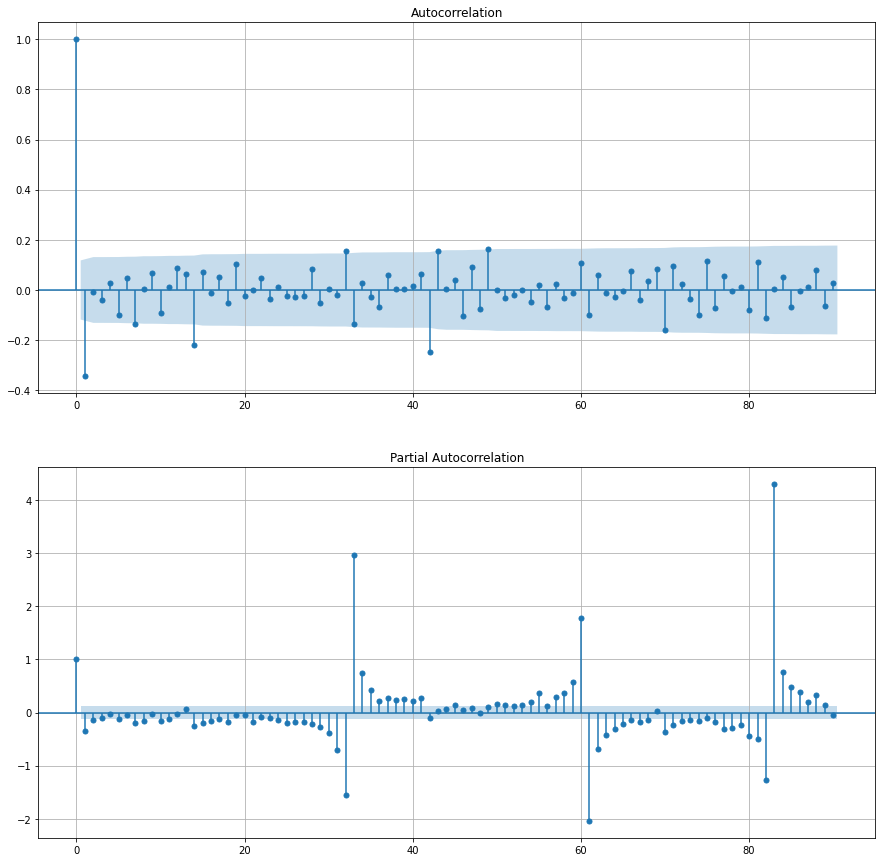

In [28]:
D = 1
d = 1

plt.figure(figsize=(15,15))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data[col[(D, d)]][(D*S+d*lag):].values.squeeze(), lags=90, ax=ax)
ax.grid(True)
plt.show()

Выводы: хотя критерий Дики-Фуллера позволяет считать ряд стационарным уже после первого сезонного дифференцирования, сезон = 14 дней, но в данных еще видно много структуры. Второе дифференцирование с лагом = 1 день этот вопрос снимает.

$SARIMA(p,d,q)(P,D,Q)_S$

### Подбор AIC модели
- Выберем оптимальную по AIC модель; 
- построим график исходного ряда и нарисуем поверх предсказания выбранной модели. 

Если модель плохо описывает данные, попробуем увеличить количество синусов и косинусов K или поменять порядки дифференцирования.

In [29]:
D = 1
d = 0
S = S  # 14
lag = lag  # 1

q = 2
p = 1

Q = 1
P = 1

In [30]:
ps = range(p + 1)
qs = range(q + 1)
Ps = range(P + 1)
Qs = range(Q + 1)

In [31]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

#### Функции для сохранения промежуточных результатов
Во время расчетов по подбору оптимальных параметров иногда происходит срубание процесса из-за нехватки ресурсов. При этом все рассчитанные до этого параметры частенько не сохраняются. Чтобы избежать этого, сделаем сохранение результата в каждом цикле. Для этого напишем соответствующую функцию и вставим ее в цикл.

In [32]:
def get_save_params(store_id):
    model_id = f"{store_id}"
    
    # the file names
    model_file_name = f"model_{model_id}.arima"
    hyperparams_file_name = f"hyperparams_{model_id}.json"
    params_df_file_name = f"params_{model_id}.csv"
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [33]:
def save_results(results, best_params, store_id, path_to_model, comment,  k_season_series, model_save=False):
    """
    The save of the current results and best params of the model calculation
    """
    # params for saving
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)
    
    # model
    if model_save:
        best_model.save(os.path.join(path_to_model, model_file_name))
    
    # best params
    best_params_dict = dict()
    best_params_dict['p'] = best_params[0]
    best_params_dict['q'] = best_params[1]
    best_params_dict['d'] = d
    best_params_dict['P'] = best_params[2]
    best_params_dict['Q'] = best_params[3]
    best_params_dict['D'] = D
    best_params_dict['S'] = S
    best_params_dict["k_season_series"] = k_season_series
    best_params_dict['Comment'] = comment

    with open(os.path.join(path_to_model, hyperparams_file_name), "w") as file:
        json.dump(best_params_dict, file)
        
    # common results (all params)
    params_df = pd.DataFrame(list(map(lambda x: x[0], results)), columns=['p', 'q', 'P', 'Q'])
    params_df['aic'] = list(map(lambda x: x[1], results))
    params_df['culc_time_in_minutes'] = list(map(lambda x: x[2], results))
    params_df_sorted = params_df.sort_values(by = 'aic', ascending=True)
    params_df_sorted.to_csv(os.path.join(path_to_model, params_df_file_name))
    
    return model_id, hyperparams_file_name, params_df_file_name, model_file_name

In [34]:
comment = f"store_id = {store_id}"

### Подбор гиперпараметров модели SARIMA

In [35]:
%%time
results = []
best_aic = float("inf")
best_params = None
warnings.filterwarnings('ignore')

for params in tqdm.tqdm(parameters_list, total=len(parameters_list)):
    start_time = datetime.now()
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(endog=data[target_col], 
                                        exog=data[feature_list], 
                                        order=(params[0], d, params[1]), 
                                        seasonal_order=(params[2], D, params[3], S)).fit()
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters (ValueError):', params)
        continue
    except LinAlgError:
        print('wrong parameters (LinAlgError):', params)
        continue
    except MemoryError as error:
        print(f"MemoryError message: {error}")
        print('wrong parameters (MemoryError):', params)
        continue
    except Exception as exception:
        print(f"Exception message: {exception}")
        print('wrong parameters (Exception):', params)
        continue
        
    end_time = datetime.now()
    model_culc_time_minutes = round((end_time - start_time).seconds / 60, 2)
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_params = params
    results.append([params, model.aic, model_culc_time_minutes])
    
    # save the current results
    model_id, hyperparams_file_name, params_df_file_name, model_file_name = \
        save_results(results, best_params, store_id, path_to_model, comment,  k_season_series)
    
warnings.filterwarnings('default')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [02:44<00:00,  6.85s/it]

Wall time: 2min 44s


## <center>Посмотрим на результат

In [36]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                               target   No. Observations:                  291
Model:             SARIMAX(1, 0, 2)x(1, 1, [1], 14)   Log Likelihood               -1635.155
Date:                              Wed, 15 Sep 2021   AIC                           3316.311
Time:                                      10:17:39   BIC                           3399.663
Sample:                                  08-13-2016   HQIC                          3349.755
                                       - 05-30-2017                                         
Covariance Type:                                opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekly_SIN_1   -17.4837     34.212     -0.511      0.609     -84.537      49.570
weekly_COS_1   -23.4538     38.845     -0.604      0.546     -99.589      52.681
weekly_SIN_2    21.5845     19.467      1.109      0.268     -16.571      59.740
weekly_COS_2     0.4587     19.417      0.024      0.981     -37.597      38.515
weekly_SIN_3     6.3112     12.786      0.494      0.622     -18.748      31.371
weekly_COS_3    21.4508     13.539      1.584      0.113      -5.084      47.986
weekly_SIN_4    -9.0244     11.162     -0.809      0.419     -30.901      12.852
weekly_COS_4     0.7323     12.309      0.059      0.953     -23.393      24.857
weekly_SIN_5   -12.1064     11.542     -1.049      0.294     -34.729      10.516
weekly_COS_5     5.9744     11.812      0.506      0.613     -17.177      29.126
weekly_SIN_6    28.0330     16.608      1.688      0.091      -4.519      60.585
weekly_COS_6   -21.2714     16.825     -1.264      0.206     -54.248      11.705
month_end       67.2260     21.677      3.101      0.002      24.739     109.713
month_start    -12.7229     24.176     -0.526      0.599     -60.106      34.661
weekday          0.0048   7756.967   6.18e-07      1.000   -1.52e+04    1.52e+04
is_weekend   -1.992e-05   9.58e+04  -2.08e-10      1.000   -1.88e+05    1.88e+05
is_even_week     0.0204   3.46e+04   5.91e-07      1.000   -6.78e+04    6.78e+04
ar.L1            0.5220      0.152      3.442      0.001       0.225       0.819
ma.L1           -0.1036      0.161     -0.645      0.519      -0.418       0.211
ma.L2            0.1386      0.092      1.513      0.130      -0.041       0.318
ar.S.L14        -0.7190      0.150     -4.797      0.000      -1.013      -0.425
ma.S.L14         0.5573      0.174      3.212      0.001       0.217       0.897
sigma2        7785.6182    598.253     13.014      0.000    6613.064    8958.173
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                89.87
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.03
Prob(H) (two-sided):                  0.08   Kurtosis:                         5.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
model_id, hyperparams_file_name, params_df_file_name, model_file_name = get_save_params(store_id)

print("model_id:", model_id)
print("hyperparams_file_name:", hyperparams_file_name)
print("params_df_file_name:", params_df_file_name)
print("model_file_name:", model_file_name)

model_id: 17
hyperparams_file_name: hyperparams_17.json
params_df_file_name: params_17.csv
model_file_name: model_17.arima


### load the best params

In [38]:
# load test
with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
    best_params_dict = json.load(file)
best_params_dict

{'p': 1,
 'q': 2,
 'd': 0,
 'P': 1,
 'Q': 1,
 'D': 1,
 'S': 14,
 'k_season_series': [1, 2, 3, 4, 5, 6],
 'Comment': 'store_id = 17'}

In [39]:
params = pd.read_csv(os.path.join(path_to_model, params_df_file_name), index_col=0)
params.head()

,p,q,P,Q,aic,culc_time_in_minutes
23,1,2,1,1,3316.310590,0.18
22,1,2,1,0,3316.621124,0.18
21,1,2,0,1,3316.643936,0.13
17,1,1,0,1,3317.579596,0.13
19,1,1,1,1,3317.772019,0.15


## sMAE calculation

In [40]:
def calc_id_sMAE(store_id, prediction_horizon=31):
    data = read_data(store_id)
    data = data_preprocessing(data, store_id)
    train, valid = data_split(data, prediction_horizon)
    
    hyperparams_file_name = f"hyperparams_{store_id}.json"    
    with open(os.path.join(path_to_model, hyperparams_file_name)) as file:
        params = json.load(file)
    
    warnings.filterwarnings('ignore')
    sales_forecast = SalesForecast(train, params=params)
    sales_forecast.fit()
    warnings.filterwarnings('default')
    
    predict = sales_forecast.predict(prediction_horizon)
    sMAE = calc_sMAE(predict, valid, train)
    return sMAE

In [41]:
%%time
sMAE = calc_id_sMAE(store_id)

Wall time: 13.3 s


In [42]:
print(f"id: {store_id}, sMAE: {sMAE: 0.3f}")

id: 17, sMAE:  0.185
